In [1]:
import numpy as np
import matplotlib
%matplotlib nbagg

from matplotlib import pyplot as plt
from dstpy3 import *
from optictools import *
from time import time
import scipy.io as sio




def pmax(t0): 
	return np.abs(b2)/gamma / t0**2

b2 = -23e-27
gamma = 0.0037
t0 = 1e-12



fr=0.05
tvec=np.linspace(-10e-12,10e-12,2**10)
t0 = fr * 20e-12
p = pmax(t0)
feld = 3.2* np.sqrt(p) / np.cosh( tvec/t0) * np.exp( -1.0j * 2 * np.pi * .01e12 * tvec)
dt = tvec[2]-tvec[1]

dob = DSTObj(feld, tvec, b2, gamma)

zetas = np.linspace(0, 1.1 * dob.zetamax,111)

# some basic tests 

In [2]:
if False:
    #abalgos:
    plt.figure()
    for k in dob.calc_ab_methodsdict.keys():
        t1 = time()
        a,b = dob.calc_ab(1.0j * zetas, method = k)
        t2 = time()

        ts = k+" %.2f"%(t2-t1)
        #plt.title(dob.calc_ab_methodnamesdict[k]+" %.2f"%(t2-t1))
        plt.plot(zetas, np.log(1./np.abs(a)), label=ts)
    plt.legend(loc=0)

    plt.figure()
    for k in dob.calc_abdiff_methodsdict.keys():
        t1 = time()
        a,b,ad,bd = dob.calc_abdiff(1.0j * zetas, method = k)
        t2 = time()

        ts = k+" %.2f"%(t2-t1)
        #plt.title(dob.calc_ab_methodnamesdict[k]+" %.2f"%(t2-t1))
        plt.plot(zetas, np.log(1./np.abs(a)), label=ts)
    plt.legend(loc=0)


#
# check whether it can handle scalar zeta input
#

if False:
    print(" ---- calc_ab Methods ----")
    for k in dob.calc_ab_methodsdict.keys():

        a,b = dob.calc_ab(1.0j * zetas[10], method = k)
        a2,b2 = dob.calc_ab(1.0j * zetas[10:12], method = k)
        print("--")
        print(a)
        print(a2)       
    print(" ---- calc_abdiff Methods ----")
    for k in dob.calc_abdiff_methodsdict.keys():
        print(k, dob.calc_abdiff_methodnamesdict[k])
        a,b, ad, bd = dob.calc_abdiff(1.0j * zetas[10], method = k)
        a2,b2, ad2, bd2 = dob.calc_abdiff(1.0j * zetas[10:12], method = k)
        print("--")
        print(a)
        print(a2)       
    

# check grid dependency (complete)

0.00316227766017  * 0.0105925372518  * 0.0354813389234  * 0.118850222744  * 0.398107170553  * 0.00316227766017  * 0.0105925372518  * 0.0354813389234  * 0.118850222744  * 0.398107170553  * 0.00316227766017  * 0.0105925372518  * 0.0354813389234  * 0.118850222744  * 0.398107170553  * 0.00316227766017  * 0.0105925372518  * 0.0354813389234  * 0.118850222744  * 0.398107170553  * 

<IPython.core.display.Javascript object>


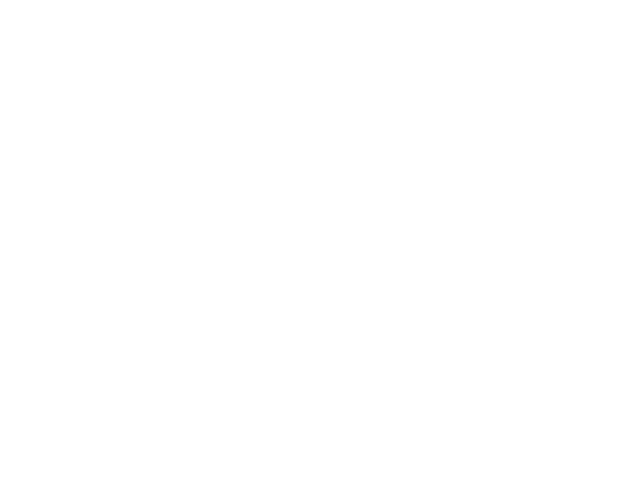

<IPython.core.display.Javascript object>


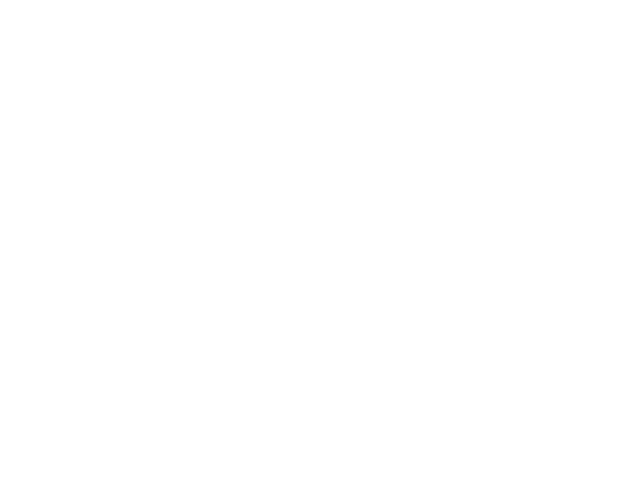

<IPython.core.display.Javascript object>


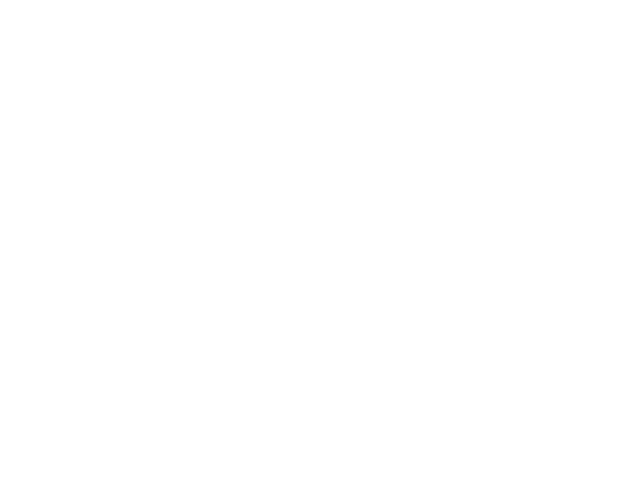

<IPython.core.display.Javascript object>


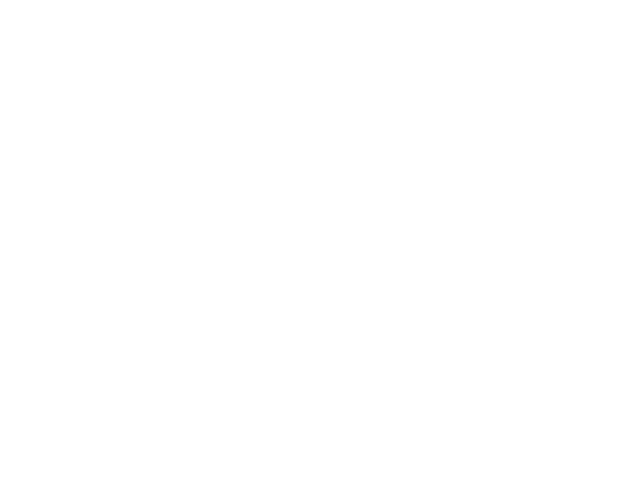

In [3]:
symbollist = ["o", 'v', 's', 'd', 'p', 'h']
algolist = ['CN','AL','AL2','FD','CD', 'RK4']    
NNlist = [9,12,15,17] #2**N points to calculate 

fracslo = 10**np.linspace(-2.5,-0.4,5)   #t0/tw fracs (Python Algs)
fracshi = 10**np.linspace(-2.5,-0.4,50)  #            (C algs)


def pfloop3(do, inizetas, Meth, verbose=False, iterations=10):
	zetas = inizetas
	for i in range(iterations):
		aa,bb = do.calc_ab(1.0j*zetas, method=Meth)
		la = np.log(1./np.abs(aa)) 
		pl = pyfindpeaks(5,la,0)
		zpeak = zetas[pl[0]]
		zetas = np.linspace( (1-0.05**i)* zpeak, (1+0.05**i)*zpeak,len(inizetas))
		if verbose:
			if i==0:
				plt.figure()
				plt.plot(zetas,la)
				plt.plot(zetas[pl],la[pl],'o' )
			print("%d - %e	  la = %e"%(i, zpeak*4.0/do.energyfactor, la[pl[0]]))
	return zpeak
#
# ATTENTION: this literally can take HOURS
#


if False:
    from optictools import pyfindpeaks
    for NN in NNlist:
        algos = algolist
       
        
        FRACM=[]
        FRACMTM = []
        for frac in fracslo:
            print(frac," * ",end="")
            tvec=np.linspace(-10e-12,10e-12,2**NN)
            t0 = frac * 20e-12
            p = pmax(t0)
            esol = 2 * t0 * p            
            feld = 1.0* np.sqrt(p) / np.cosh( tvec/t0) #* np.exp( -1.0j * 2 * np.pi * .01e12 * tvec)
            dob = DSTObj( feld, tvec, b2, gamma)
            inizetas = np.linspace(1e-8,1.1 * dob.zetamax,25)
            ALGOM = [frac]
            for i in range(len(algos)):        
                zm = pfloop3(dob, inizetas, algos[i])
                ALGOM.append(1-zm*4.0/dob.energyfactor/esol)    
            FRACM.append(ALGOM)

        for frac in fracshi:
            tvec=np.linspace(-10e-12,10e-12,2**NN)
            t0 = frac * 20e-12
            p = pmax(t0)
            esol = 2 * t0 * p
            feld = 1.0* np.sqrt(p) / np.cosh( tvec/t0) #* np.exp( -1.0j * 2 * np.pi * .01e12 * tvec)
            dob = DSTObj( feld, tvec, b2, gamma)
            inizetas = np.linspace(1e-8,1.1 * dob.zetamax,50)
            zm = pfloop3(dob, inizetas,'TMC')
            zm2 = pfloop3(dob, inizetas,'FDC'     )
            zm3 = pfloop3(dob, inizetas,'RK4C'     )
            FRACMTM.append([frac, np.abs (1-zm*4.0 / dob.energyfactor / esol),
                           np.abs (1-zm2*4.0 / dob.energyfactor / esol),
                           np.abs (1-zm3*4.0 / dob.energyfactor / esol)])
            
        np.savetxt("testdata/algs%d.dat"%NN, np.array( FRACM) ) #F)
        np.savetxt("testdata/ref%d.dat"%NN, np.array(FRACMTM)) #FRef)
            
if True:
   for NN in NNlist:
        F=np.loadtxt( "testdata/algs%d.dat"%NN) 
        FRef = np.loadtxt("testdata/ref%d.dat"%NN)
        plt.figure()
        plt.loglog(FRef[:,0], FRef[:,1], 'o-', ms=4, label = "REF TMC")
        plt.loglog(FRef[:,0], FRef[:,2], 'p-', ms=4, label = "REF FDC")
        plt.loglog(FRef[:,0], FRef[:,3], 's-', ms=4, label = "REF RK4C")
        
        for ii in range(len(algos)):
            plt.loglog(F[:,0], F[:,ii+1],symbollist[ii], label =algolist[ii], ms=8)
       
        plt.xlabel(r"$T_0 / T_{\rm Window}$")
        plt.ylabel(r"$1 - E_{\rm DST}/E_{\rm sol}$")    
        titles = r"$N=2^{%d}$"%(NN)
        plt.title(titles)
        plt.legend(loc=0)
        plt.savefig("testdata/%d.pdf"%NN)

# check calculation of da/dzeta and Newton-rootfinding (complete)

<IPython.core.display.Javascript object>


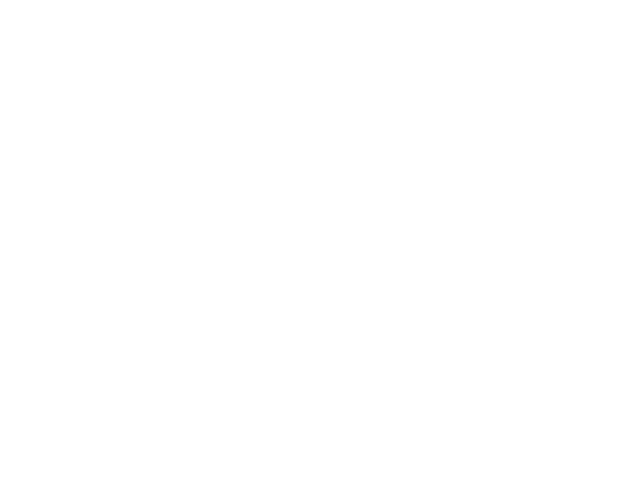

<IPython.core.display.Javascript object>


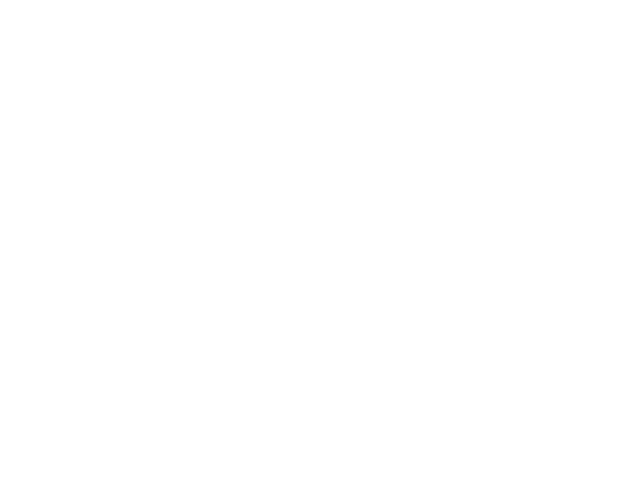

<IPython.core.display.Javascript object>


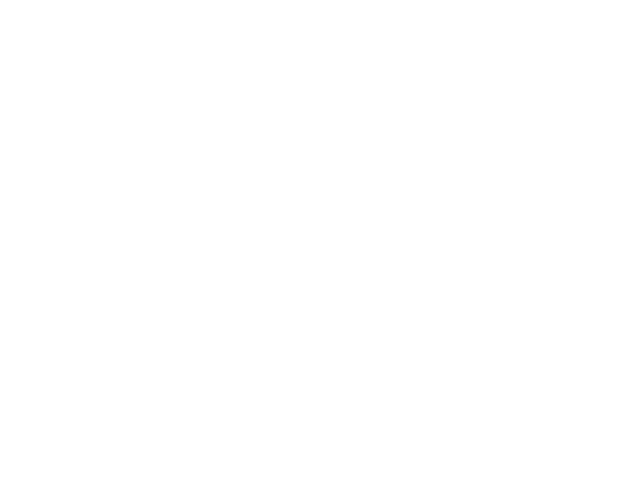

<IPython.core.display.Javascript object>


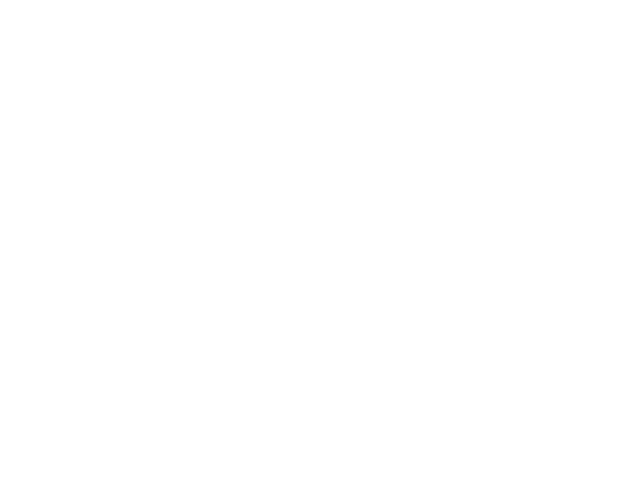

 ------i1 = 3    i2 = 15   -------
zeta1 = 0.000000 +  0.007097 i    a = 0.052399 +  -0.277133 i   
zeta2 = 0.002096 +  0.009462 i    a = 0.054693 +  -0.133560 i    dzeta : 0.002096 +  0.002366 i

   numerical deriv dy = 47.932403 +  30.464051 i
   numerical deriv dx = 45.916534 +  29.186301 i
            deriv ALc = 46.791252 +  29.739108 i
num1     integrated a = 0.080821 +  -0.099878 i   (29.54 percent deviation) 
num2     integrated a = 0.079617 +  -0.107326 i   (25.07 percent deviation) 
ALC      integrated a = 0.080143 +  -0.104098 i   (26.98 percent deviation) 


 ------i1 = 6    i2 = 12   -------
zeta1 = -0.006289 +  0.014194 i    a = -0.192336 +  -0.059092 i   
zeta2 = -0.004193 +  0.016559 i    a = -0.134070 +  -0.031009 i    dzeta : 0.002096 +  0.002366 i

   numerical deriv dy = 22.075779 +  -10.793232 i
   numerical deriv dx = 21.501291 +  -10.607685 i
            deriv ALc = 21.752661 +  -10.687834 i
num1     integrated a = -0.120523 +  -0.029497 i   (9.91 percent deviati

<IPython.core.display.Javascript object>


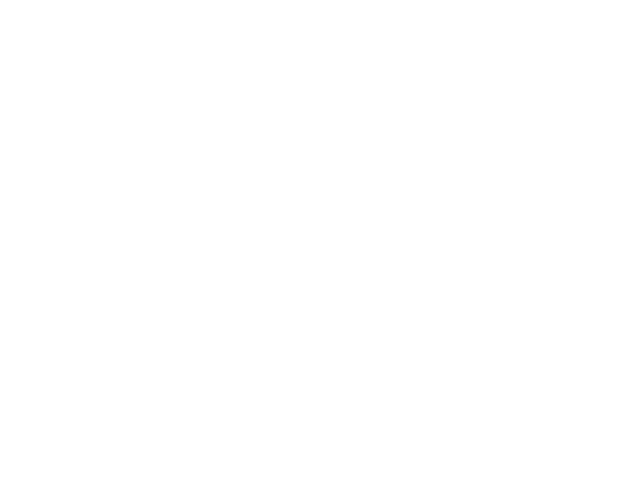

In [4]:
import numpy as np
import matplotlib
from plottingtools import *
%matplotlib nbagg
from dstpy3 import *
from optictools import *
from plottingtools import *

def pmax(t0): 
	return np.abs(b2)/gamma / t0**2

b2 = -23e-27
gamma = 0.0037
t0 = 1e-12
tvec=np.linspace(-10e-12,10e-12,2**10)
p = np.abs(b2)/gamma / t0**2
feld = 2.2* np.sqrt(p) / np.cosh( tvec/t0) * np.exp( -1.0j * 2 * np.pi * .1e12 * tvec)

dob = DSTObj( feld, tvec, b2, gamma)
evals = dob.calc_evals()

# calc a
ofak = 0.02
opoints = 31
epoints = 21
ov = np.linspace(0, 0.01, opoints)#np.linspace(-dob.ommax, dob.ommax, opoints) * ofak
ov = np.linspace(-dob.ommax, dob.ommax, opoints) * ofak
ev = np.linspace(0, dob.zetamax, epoints)
oo,ee = np.meshgrid(ov,ev)
zetas = oo + 1.0j * ee
aa = np.zeros([epoints, opoints], dtype=complex)
for i in range(epoints):
    a,b = dob.calc_ab(zetas[i,:], method="TMC")
    aa[i,:]=a
   
def imshowhelper(vals):  
    plt.imshow(vals, origin = 'lower', cmap=sunrise(),
              extent=[np.min(ov), np.max(ov), np.min(ev), np.max(ev)])
plt.figure()
imshowhelper(1./np.abs(aa))
plt.plot(np.real(evals), np.imag(evals),'o', mfc='1.0')

plt.xlabel("real(zeta)")
plt.ylabel("imag(zeta)")
plt.title("log(1/abs(a(zeta)))")
plt.xlim(-0.04, 0.04)
plt.ylim(-0.01, 0.05)


#
# calculate adiff 
#


for methds in ['ALC']:
    aa = np.zeros([epoints, opoints], dtype=complex)
    bb = np.zeros([epoints, opoints], dtype=complex)
    aad = np.zeros([epoints, opoints], dtype=complex)
    bbd = np.zeros([epoints, opoints], dtype=complex)
    
    for i in range(epoints):
        a,b,ad,bd = dob.calc_abdiff(zetas[i,:], method=methds)
        aa[i,:]=a
        aad[i,:] = ad
        
    plt.figure()
    plt.quiver( oo,ee, np.real(aad), np.imag(aad))
    plt.plot(np.real(evals), np.imag(evals),'o')
    plt.xlim(-0.04, 0.04)
    plt.ylim(-0.01, 0.05)
    plt.xlabel("real(zeta)")
    plt.ylabel("imag(zeta)")
    plt.title("deriv " + methds)
    plt.savefig("testdata/gradient_%s.pdf"%methds) 
#
# calc adiff from calculated grid (difference method)
#
    
    
dx = ov[2]-ov[1]
dy = ev[2]-ev[1]
greal = np.gradient(np.real(aa))
gimag = np.gradient(np.imag(aa))


d1 =-1.0j * greal[0] / dy +  gimag[0]/dy
d2 = greal[1] / dx +  1.0j * gimag[1]/dx

plt.figure()
plt.quiver(oo,ee, np.real(d1), np.imag(d1), color='red')
plt.title(" numerical -j * uy + vy)")
plt.xlim(-0.04, 0.04)
plt.ylim(-0.01, 0.05)
plt.xlabel("real(zeta)")
plt.ylabel("imag(zeta)")
plt.savefig("testdata/gradient_num1.pdf")

plt.figure()
plt.quiver(oo,ee, np.real(d2), np.imag(d2), color='green')
plt.title(" numerical ux + i * vx")          
plt.xlim(-0.04, 0.04)
plt.ylim(-0.01, 0.05) 
plt.xlabel("real(zeta)")
plt.ylabel("imag(zeta)")
plt.savefig("testdata/gradient_num2.pdf")

#
# check calculated gradient by integrating: a(zeta') = a(zeta) + adiff * zetadiff for some cases
#

def cs(z):
    return "%.6f +  %.6f i"%(np.real(z), np.imag(z))
from numpy.random import randint


for kk in range(12):
    i1 = randint(3,epoints-3)
    i2 = randint(3,opoints-3)

    id1 = i1 + 1
    id2 = i2 +1    

    zeta1 = zetas[i1,i2]
    zeta2 = zetas[id1,id2]

    dzeta = zeta2-zeta1


    resad1 = aa[i1,i2]+d1[i1,i2] *dzeta
    resad2 = aa[i1,i2]+d2[i1,i2] *dzeta
    resadal = aa[i1,i2]+aad[i1,i2] *dzeta
    reldiff1 = float(np.abs( (aa[id1,id2]-resad1)/aa[id1,id2])*100)
    reldiff2 = float(np.abs( (aa[id1,id2]-resad2)/aa[id1,id2])*100)
    reldiffal= float(np.abs( (aa[id1,id2]-resadal)/aa[id1,id2])*100)
   
    print(" ------i1 = %d    i2 = %d   -------"%(i1,i2))
  
    print("zeta1 = %s    a = %s   "%(cs(zeta1), cs( aa[i1,i2])))
    print("zeta2 = %s    a = %s    dzeta : %s"%(cs(zeta2),cs( aa[id1,id2]), cs(dzeta) ))
    print("\n   numerical deriv dy = %s"%cs(d1[i1,i2]))
    print("   numerical deriv dx = %s"%cs(d2[i1,i2]))    
    print("            deriv ALc = %s"%cs(aad[i1,i2]))
        
  
    
    print("num1     integrated a = %s   (%.2f percent deviation) "%(cs( resad1), reldiff1))
    print("num2     integrated a = %s   (%.2f percent deviation) "%(cs( resad2), reldiff2))
    print("ALC      integrated a = %s   (%.2f percent deviation) \n\n"%(cs( resadal), reldiffal))

#
# check newton rootfinding
#

#calc eigenvalues directly 
evals = dob.calc_evals()

plt.figure()
plt.plot(np.real(evals), np.imag(evals),'v',mfc='y', ms=12)

#
iters = 15
for testzetas in range(500):

    i1 = randint(3,epoints-3)
    i2 = randint(3,opoints-3) 
    zs = zetas[i1,i2]
    a = aa[i1,i2]
    ad = aad[i1,i2]

    for nnnumer in range(iters):
        #print("zeta %.5f i%.5f   a = %.2e i %2e        ad %.2e i%.2e"%(np.real(zs), np.imag(zs), np.real(a), np.imag(a),
        #                                                        np.real(ad), np.imag(ad)))
        zs = zs - a/ad 
        a,b,ad,bd = dob.calc_abdiff(zs)
        cval = 1-nnnumer/iters
        plt.plot(np.real(zs), np.imag(zs),'o',ms=4, mfc = str(cval))

plt.xlim([-0.06,0.06])
plt.ylim([0.0,0.05])
plt.text(-0.05, 0.005,"triangles: matrix evals,\nwhite circles: root finding starting positions (random)\nblack circles: root finding results")
plt.xlabel("real(zeta)")  
plt.ylabel("imag(zeta)")  
plt.title("AL-rootfinding with Newton")
plt.savefig("testdata/newtonrootfinding.pdf")



       

In [5]:
dob.help()

calc_ab methods available:
                           RK4C : Runge-Kutta 4 (Python)
                           CN : Crank Nicolson (Python)
                           TMC : Transfer Matrix (C)
                           AL2 : Ablowitz Ladik Norm (Python)
                           RK4 : Runge-Kutta 4 (Python)
                           AL : Ablowitz Ladik (Python)
                           FD : Forward Discretization (Python)
                           CD : Central Discretization (Python)
                           TM : Transfer Matrix (Python)
                           FDC : Forward Discretization (C)


calc_abdiff methods available:
                           AL : Ablowitz Ladik (Python)
                           ALC : Ablowitz Ladik (C)

eigenvalue calculation: use .calc_evals() BUT this is slow and gives N false (mirrored) evals.


# accuracy and energy

In [6]:
import numpy as np
import matplotlib
%matplotlib nbagg

from matplotlib import pyplot as plt
from dstpy3 import *
from optictools import *
from time import time
import scipy.io as sio


b2 = -23e-27
gamma = 0.042

def ppeak(t0):
    return np.abs(b2) / gamma / t0**2

def ecutrel( t0tw):
    return 1 - np.tanh( 1. / t0tw / 2.)


def pfloop3(do, inizetas, Meth, verbose=False, iterations=10):
	zetas = inizetas
	for i in range(iterations):
		aa,bb = do.calc_ab(1.0j*zetas, method=Meth)
		la = np.log(1./np.abs(aa)) 
		pl = pyfindpeaks(5,la,0)
		zpeak = zetas[pl[0]]
		zetas = np.linspace( (1-0.05**i)* zpeak, (1+0.05**i)*zpeak,len(inizetas))
	return zpeak



def calc_cut_energy_num_int(t0tw):
    #check numerical field integration
    EcutMarray = []
    TW = 5e-12
    for frac in t0tw:
        t0 = frac * TW
        tvec = np.linspace(-TW/2, TW/2., 2**16)
        dt = tvec[2]-tvec[1]
        p =  ppeak(t0)
        esoltheo = 2 * t0 * p
        field = np.sqrt( p) / np.cosh(tvec/t0)
        EcutMarray.append( [ frac,  np.abs( 1 - np.sum(np.abs(field)**2) *dt / esoltheo) ])
    return np.array(EcutMarray)

#check DST accuracy, vary t0/twindow
def calc_dst_soliton_deviation_t0twvary(t0tw, inizetapoints, method, Npoints):
    TW = 5e-12
    EM = []
    for frac in t0tw:
        tvec  = np.linspace(-TW/2,TW/2, 2**Npoints)
        dt = tvec[2]-tvec[1]
        t0 = frac * TW
        p =  ppeak(t0)
        esoltheo = 2 * t0 * p
        field = np.sqrt( p) / np.cosh(tvec/t0)
        dob = DSTObj( field, tvec, b2, gamma)
        inizetas = np.linspace(1e-10, dob.zetamax, 21)
        zm = pfloop3(dob, inizetas, method, iterations=10)
        pointdensity = 2**Npoints/TW * t0
        EM.append([frac, np.abs( 1- zm * 4.0 / dob.energyfactor / esoltheo), pointdensity])
    return np.array(EM)

def calc_dst_soliton_deviation_density(t0twfrac , densities, zetapts, method ):
    T0 = 1e-12
    P = ppeak(T0)
    esoltheo = 2 * P * T0
    EM = []
    for dens in densities:
            TW2 = t0twfrac * T0
            dt = T0 / dens
            pts = np.ceil( TW2 / dt)
            tvec = np.linspace(-TW2/2.0 , TW2/2.0, pts)
           
            feld  = np.sqrt(P) / np.cosh(tvec/T0)            
            dob = DSTObj(feld, tvec, b2, gamma)
            inizetas = np.linspace(1e-10, dob.zetamax, zetapts)
            zm = pfloop3(dob, inizetas, method, iterations=10)
            EM.append( [dens, np.abs( 1- zm * 4.0 / dob.energyfactor / esoltheo), t0twfrac])
    return np.array(EM)
    

In [7]:
t0twpts = 10    
densitypts = 10    
t0tw = 10**np.linspace(-3,-0.5,t0twpts)
densities = 10**np.linspace(1,4,densitypts)

zetapts = 31
NNs = [10, 12]
twt0s = [10, 20,30]
### t0twvariation


EDt0tw = {}
EDdens = {}
methods = ['TMC', 'RK4C']

if True:
    for N in NNs:
        for meth in methods:
            ids = meth+str(N)
            print(ids)
            EDt0tw[ids] = calc_dst_soliton_deviation_t0twvary( t0tw, zetapts, meth, N)
    sio.savemat("testdata/data_t0_tw_vari", EDt0tw)        

    for twt0 in twt0s:
        for meth in methods:
            ids = meth+str(twt0)
            print(ids)        
            EDdens[ids] = calc_dst_soliton_deviation_density( twt0, densities,zetapts,  meth)
    sio.savemat("testdata/data_density_vari", EDdens)                
        
    

TMC10
RK4C10
TMC12
RK4C12
TMC10
RK4C10
TMC20
RK4C20
TMC30
RK4C30


c:\Users\chmahnke\Documents\optik\programme\python\dstpy3\dstpy_cythonloops_wrapper.py:68: RuntimeWarning: invalid value encountered in true_divide
  UU00 = coshkdxm - 1.0j*zzet / kk * sinhkdxm
c:\Users\chmahnke\Documents\optik\programme\python\dstpy3\dstpy_cythonloops_wrapper.py:69: RuntimeWarning: divide by zero encountered in true_divide
  UU01 = qq/kk * sinhkdxm
c:\Users\chmahnke\Documents\optik\programme\python\dstpy3\dstpy_cythonloops_wrapper.py:69: RuntimeWarning: invalid value encountered in true_divide
  UU01 = qq/kk * sinhkdxm
c:\Users\chmahnke\Documents\optik\programme\python\dstpy3\dstpy_cythonloops_wrapper.py:69: RuntimeWarning: invalid value encountered in multiply
  UU01 = qq/kk * sinhkdxm
c:\Users\chmahnke\Documents\optik\programme\python\dstpy3\dstpy_cythonloops_wrapper.py:70: RuntimeWarning: divide by zero encountered in true_divide
  UU10 = -1.0 * np.conj(qq) / kk * sinhkdxm
c:\Users\chmahnke\Documents\optik\programme\python\dstpy3\dstpy_cythonloops_wrapper.py:70: Ru

<IPython.core.display.Javascript object>


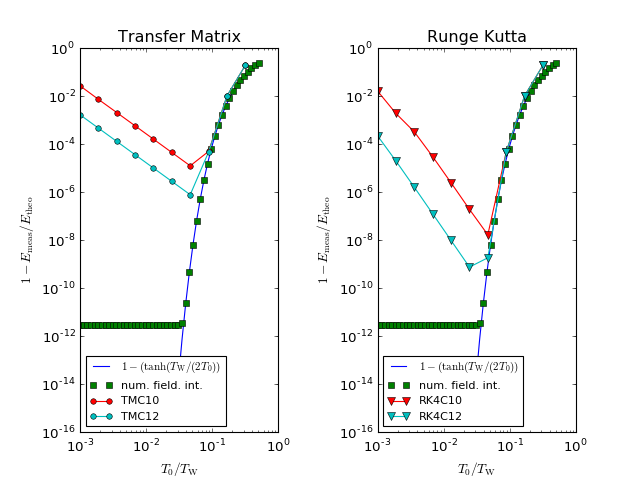

<IPython.core.display.Javascript object>


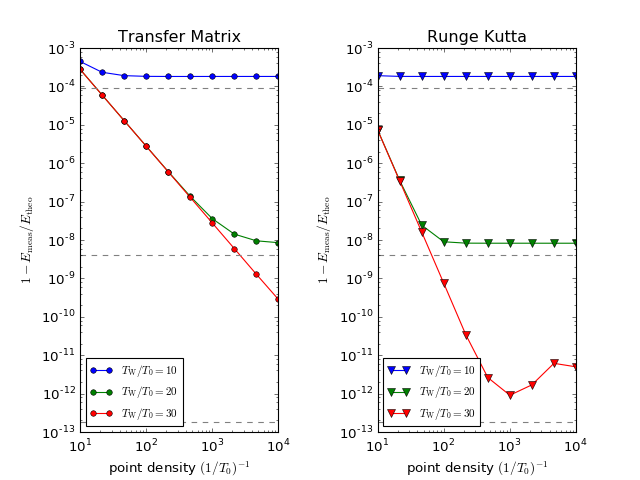

In [8]:
plt.rcParams['legend.fontsize']=10
plt.rcParams['figure.subplot.wspace']=0.5
EDt0tw = sio.loadmat("testdata/data_t0_tw_vari")    
EDdense = sio.loadmat("testdata/data_density_vari")  

#cutoff-energy
tx = 10**np.linspace(-3,-.3)
EcutM = calc_cut_energy_num_int(tx)


symbl = ['o-', 'v-']
mss = [5,8]

axs = []
titles = ["Transfer Matrix", "Runge Kutta"]

plt.figure()


for i,meth in enumerate( methods) :
    ax=plt.subplot(1,2,i+1)
    axs.append(ax)
    
    plt.plot(EcutM[:,0], ecutrel(EcutM[:,0]), label=r"$1-({\rm tanh}(T_{\rm W}/(2T_0))$")
    plt.plot(tx, EcutM[:,1], 's', label="num. field. int.")
    for N in NNs:    
        ids = meth+str(N)
        M=EDt0tw[ids]
        plt.loglog(M[:,0], M[:,1], symbl[i], ms = mss[i], label=ids)
    plt.legend(loc=0, ncol=1)
    plt.title(titles[i])  
for ax in axs:        
    ax.set_xlabel(r"$T_0/T_{\rm W}$")
    ax.set_ylabel(r"$1-E_{\rm meas}/E_{\rm theo}$")
    
        
plt.figure()
axs = []
titles = ["Transfer Matrix", "Runge Kutta"]
for i,meth in enumerate(methods):
    ax=plt.subplot(1,2,i+1)
    axs.append(ax)
    for twt0 in twt0s:    
        ids = meth+str(twt0)
        M = EDdens[ids]
        labelstr = r"$T_{\rm W}/T_0=%d$"%twt0
        plt.loglog(M[:,0], M[:,1], symbl[i], ms=mss[i], label=labelstr)
    for k,twt0 in enumerate( twt0s):
        plt.axhline(y = ecutrel(1/twt0),c ='0.5',dashes =(5,5))
    plt.title(titles[i])  
    plt.legend(loc=0, ncol=1)  
for ax in axs:        
    ax.set_ylabel(r"$1-E_{\rm meas}/E_{\rm theo}$")
    ax.set_xlabel(r"point density $(1/T_0)^{-1}$")

        

      

In [9]:
def calc_dst_soliton_deviation_densityB(t0twfrac , dens, zetapts, method, pixmod ):
    T0 = 1e-12
    P = ppeak(T0)
    esoltheo = 2 * P * T0
    EM = []
    
    TW2 = t0twfrac * T0
    dt = T0 / dens
    pts = np.ceil( TW2 / dt)
    tvec = np.linspace(-TW2/2.0 , TW2/2.0, pts)

    feld  = np.sqrt(P) / np.cosh(tvec/T0)
    for i in range(pixmod):
        feld[i]=0
        feld[-(i+1)]=0
    dob = DSTObj(feld, tvec, b2, gamma)
    inizetas = np.linspace(1e-10, dob.zetamax, zetapts)
    zm = pfloop3(dob, inizetas, method, iterations=10)
    return np.abs( 1- zm * 4.0 / dob.energyfactor / esoltheo)
    
t0twfrac = 20
dens =400                  
for pixmod in range(4):
    print(pixmod, calc_dst_soliton_deviation_densityB(t0twfrac, dens, 31, 'RK4C', pixmod))
    

0 8.24768597862e-09
1 8.27611223997e-09
2 8.30985091849e-09
3 8.35150537615e-09
